# Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Utils

In [2]:
def compute_oec(control_spend, treatment_spend):
    control_mean = np.mean(control_spend)
    treatment_mean = np.mean(treatment_spend)
    oec = (treatment_mean - control_mean) / control_mean
    return oec

def compute_metrics(is_positive, is_obs_positive, value_tn, value_fn, value_fp, value_tp):
    n_tn = ((~is_obs_positive) & (~is_positive)).sum()
    n_fn = ((~is_obs_positive) & (is_positive)).sum()
    n_fp = ((is_obs_positive) & (~is_positive)).sum()
    n_tp = ((is_obs_positive) & (is_positive)).sum()
    n_pos = is_positive.sum()
    n_neg = (~is_positive).sum()
    n_obs_pos = is_obs_positive.sum()
    n_obs_neg = (~is_obs_positive).sum()
    n = n_pos + n_neg
    confidence = n_tn / n_neg
    power = n_tp / n_pos
    accuracy = (n_tp + n_tn) / n
    precision = n_tp / n_obs_pos
    false_positive_rate = n_fp / n_obs_pos
    false_negative_rate = n_fn / n_obs_neg
    p_value = n_fp / n_neg
    expected_value = (n_tn * value_tn + n_fn * value_fn + n_fp * value_fp + n_tp * value_tp) / n
    metrics = {
        "n_tn": n_tn,
        "n_fn": n_fn,
        "n_fp": n_fp,
        "n_tp": n_tp,
        "n_pos": n_pos,
        "n_neg": n_neg,
        "n_obs_pos": n_obs_pos,
        "n_obs_neg": n_obs_neg,
        "n": n,
        "threshold": threshold,
        "confidence": confidence,
        "power (recall)": power,
        "accuracy": accuracy,
        "precision": precision,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "p-value": p_value,
        "expected value": expected_value,
    }
    return metrics

# Input

In [3]:
spend_distribution = np.concatenate([np.zeros(100_000), 5 + np.random.beta(a=1, b=9, size=100_000) * 100])
spend_distribution_hp = spend_distribution * 1.05
p_positive = .20
n_iters = 10_000
value_tn = 0
value_fn = 0
value_fp = -2_000_000
value_tp = 2_000_000

# Simulation

In [4]:
results = pd.DataFrame()

for label, control_n, treatment_n in (["control: 1k users, treatment: 1k users", 1_000, 1_000], ["control: 10k users, treatment: 10k users", 10_000, 10_000]):
    for iter in range(n_iters):
        control_spend = np.random.choice(spend_distribution, size=control_n, replace=True)
        is_positive = np.random.choice([True, False], p=[p_positive, 1-p_positive])
        treatment_distribution = spend_distribution_hp if is_positive else spend_distribution
        treatment_spend = np.random.choice(treatment_distribution, size=treatment_n, replace=True)
        oec = compute_oec(control_spend, treatment_spend)
        results = results._append({
            "label": label,
            "is_positive": is_positive,
            "oec": oec
        }, ignore_index=True)

In [5]:
scores = pd.DataFrame()

for label in results["label"].unique():
    results_label = results[results["label"]==label]
    for threshold in sorted(results_label["oec"].unique()):
        is_positive = results_label.loc[:, "is_positive"]
        is_obs_positive = results_label.loc[:, "oec"] > threshold
        metrics = compute_metrics(
            is_positive=is_positive,
            is_obs_positive=is_obs_positive,
            value_tn=value_tn,
            value_fn=value_fn,
            value_fp=value_fp,
            value_tp=value_tp,
        )
        scores = scores._append({
            "label": label,
            **metrics,
        }, ignore_index=True)

# Plots

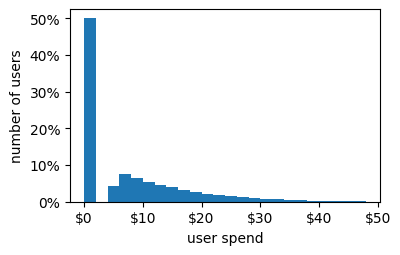

In [6]:
fig, ax = plt.subplots(figsize=(4, 2.5))

ax.hist(spend_distribution, bins=range(0,50,2))
ax.set_yticks(range(0, 100_001, 20_000), [f'{y/len(spend_distribution):.0%}' for y in range(0, 100_001, 20_000)])
ax.set_xticks(range(0, 51, 10), [f'${x}' for x in range(0, 51, 10)])
ax.set_xlabel("user spend")
ax.set_ylabel("number of users")

fig.savefig("user_spend.png", dpi=200, bbox_inches="tight");

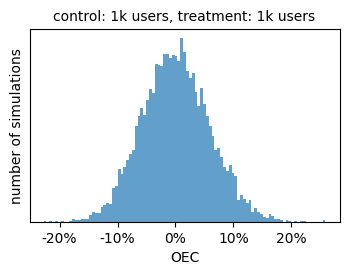

In [7]:
fig, ax = plt.subplots(figsize=(4, 2.5))

label = "control: 1k users, treatment: 1k users"
results_label = results.loc[results["label"]==label, :]
bins=np.linspace(
    results_label.loc[~results_label["is_positive"],"oec"].min(),
    results_label.loc[~results_label["is_positive"],"oec"].max(), 100)
hist_negative = ax.hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
ax.set_yticks([])
ax.set_xticks(ax.get_xticks()[1:-1], [f"{x:.0%}" for x in ax.get_xticks()[1:-1]])
ax.set_title(label, fontsize=10)
ax.set_xlabel("OEC")
ax.set_ylabel("number of simulations")

fig.savefig("negatives_single.png", dpi=200, bbox_inches="tight");

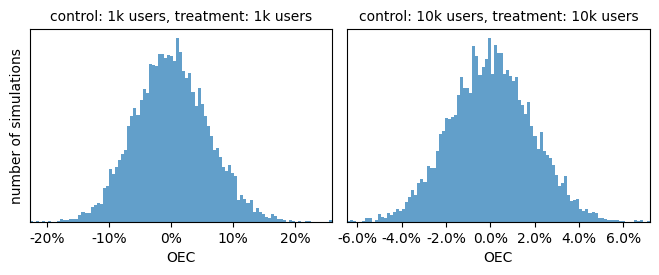

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex="col")
plt.subplots_adjust(wspace=.05)

for enum, label in enumerate(results["label"].unique()):
    results_label = results.loc[results["label"]==label, :]
    bins=np.linspace(
        results_label.loc[~results_label["is_positive"],"oec"].min(),
        results_label.loc[~results_label["is_positive"],"oec"].max(), 100)
    hist_negative = axs[enum].hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
    hn_argmax_left = np.argmax(hist_negative[0]>0)
    hn_argmax_right = np.argmax(hist_negative[0][::-1]>0)
    xlim_left = hist_negative[1][hn_argmax_left]
    xlim_right = hist_negative[1][-hn_argmax_right-1]
    axs[enum].set_xlim(xlim_left, xlim_right)
    axs[enum].set_yticks([])
    axs[enum].set_xlabel("OEC")
    axs[enum].set_xticks(axs[enum].get_xticks()[1:-1], [f"{x:.0%}" if enum == 0 else f"{x:.1%}" for x in axs[enum].get_xticks()[1:-1]])
    axs[enum].set_title(label, fontsize=10)

axs[0].set_ylabel("number of simulations")

fig.savefig("negatives.png", dpi=200, bbox_inches="tight");

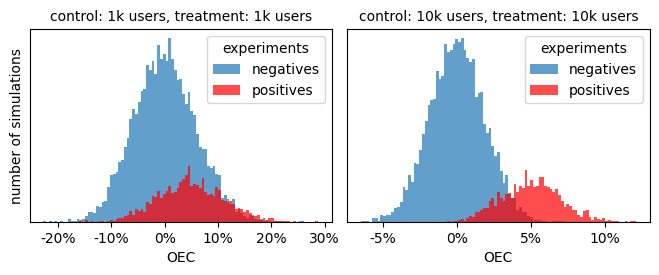

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), sharex="col")
plt.subplots_adjust(wspace=.05)

for enum, label in enumerate(results["label"].unique()):
    results_label = results.loc[results["label"]==label, :]
    bins=np.linspace(results_label["oec"].min(), results_label["oec"].max(), 100)
    hist_negative = axs[enum].hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
    hist_positive = axs[enum].hist(results_label.loc[results_label["is_positive"],"oec"], alpha=.7, bins=bins, color="red", label="positives")
    axs[enum].set_yticks([])
    axs[enum].set_xlabel("OEC")
    axs[enum].set_xticks(axs[enum].get_xticks()[1:-1], [f"{x:.0%}" for x in axs[enum].get_xticks()[1:-1]])
    axs[enum].legend(title="experiments")
    axs[enum].set_title(label, fontsize=10)

axs[0].set_ylabel("number of simulations")

fig.savefig("positives_vs_negatives.png", dpi=200, bbox_inches="tight");

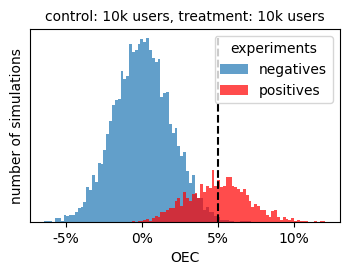

In [10]:
fig, ax = plt.subplots(figsize=(4, 2.5))

results_label = results.loc[results["label"]=="control: 10k users, treatment: 10k users", :]
bins=np.linspace(results_label["oec"].min(), results_label["oec"].max(), 100)
hist_negative = ax.hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
hist_positive = ax.hist(results_label.loc[results_label["is_positive"],"oec"], alpha=.7, bins=bins, color="red", label="positives")
max_vlines_upper = max(hist_negative[0])
ax.set_yticks([])
ax.vlines(.05, 0, max_vlines_upper, ls="--", color="black")
ax.set_xlabel("OEC")
ax.set_xticks(ax.get_xticks()[1:-1], [f"{x:.0%}" for x in ax.get_xticks()[1:-1]])
ax.legend(title="experiments")
ax.set_title(label, fontsize=10)

ax.set_ylabel("number of simulations")

fig.savefig("positives_vs_negatives_single.png", dpi=200, bbox_inches="tight");

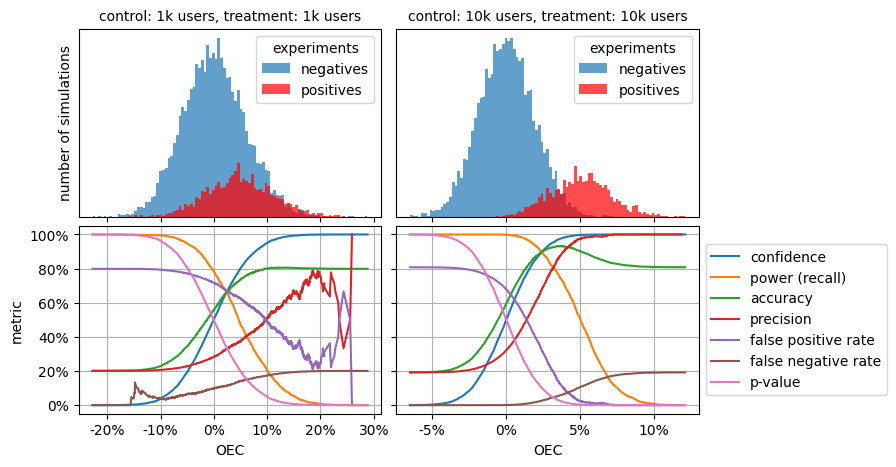

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex="col")
plt.subplots_adjust(wspace=.05, hspace=.05)

score_names = ["confidence", "power (recall)", "accuracy", "precision", "false positive rate", "false negative rate", "p-value"]

for enum, label in enumerate(scores["label"].unique()):
    results_label = results.loc[results["label"]==label, :]
    scores_label = scores.loc[scores["label"]==label, :]
    bins=np.linspace(results_label["oec"].min(), results_label["oec"].max(), 100)
    hist_negative = axs[0,enum].hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
    hist_positive = axs[0,enum].hist(results_label.loc[results_label["is_positive"],"oec"], alpha=.7, bins=bins, color="red", label="positives")
    max_vlines_upper = max(hist_negative[0]) if label == "control: 10k users, treatment: 10k users" else max_vlines_upper
    [axs[1,enum].plot(scores_label["threshold"], scores_label[score_name], label=score_name) for score_name in score_names]
    axs[0,enum].set_yticks([])
    axs[1,enum].set_xticks(axs[1,enum].get_xticks()[1:-1], [f"{x:.0%}" for x in axs[1,enum].get_xticks()[1:-1]])
    axs[1,enum].set_xlabel("OEC")
    axs[0,enum].legend(title="experiments")
    axs[1,enum].grid()
    axs[0,enum].set_title(label, fontsize=10)

axs[1,1].set_yticklabels(["" for t in range(6)])
axs[1,0].set_yticks(axs[1,0].get_yticks()[1:-1], [f"{x:.0%}" for x in axs[1,0].get_yticks()[1:-1]])
axs[0,0].set_ylabel("number of simulations")
axs[1,0].set_ylabel("metric")
axs[1,1].legend(bbox_to_anchor=(1, 0.5), loc="center left")

fig.savefig("positives_vs_negatives_metrics.png", dpi=200, bbox_inches="tight");

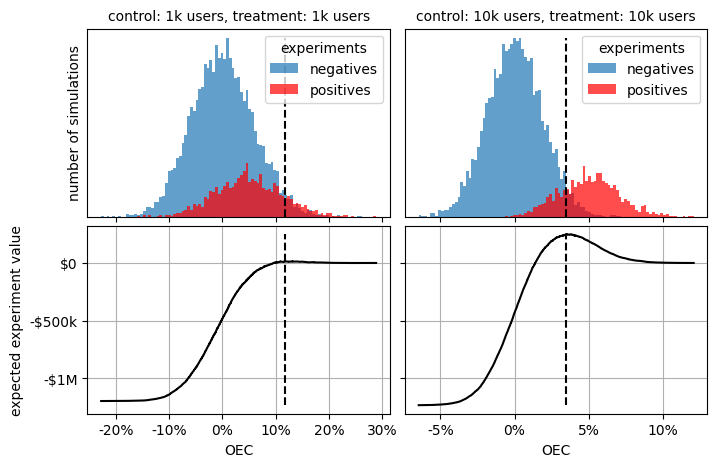

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex="col")
plt.subplots_adjust(wspace=.05, hspace=.05)

for enum, label in enumerate(scores["label"].unique()):
    results_label = results.loc[results["label"]==label, :]
    scores_label = scores.loc[scores["label"]==label, :]
    bins=np.linspace(results_label["oec"].min(), results_label["oec"].max(), 100)
    hist_negative = axs[0,enum].hist(results_label.loc[~results_label["is_positive"],"oec"], alpha=.7, bins=bins, label="negatives")
    hist_positive = axs[0,enum].hist(results_label.loc[results_label["is_positive"],"oec"], alpha=.7, bins=bins, color="red", label="positives")
    axs[1,enum].plot(scores_label["threshold"], scores_label["expected value"], color="black")
    axs[0,enum].vlines(scores_label.loc[scores_label["expected value"].idxmax(),"threshold"], 0, max(hist_negative[0]), ls="--", color="black")
    axs[1,enum].vlines(scores_label.loc[scores_label["expected value"].idxmax(),"threshold"], scores["expected value"].min().min(), scores["expected value"].max().max(), ls="--", color="black")
    axs[0,enum].set_yticks([])
    axs[1,enum].set_xticks(axs[1,enum].get_xticks()[1:-1], [f"{x:.0%}" for x in axs[1,enum].get_xticks()[1:-1]])
    axs[1,enum].set_xlabel("OEC")
    axs[0,enum].legend(title="experiments")
    axs[1,enum].grid()
    axs[0,enum].set_title(label, fontsize=10)

axs[1,1].set_yticklabels(["" for t in range(6)])
axs[1,0].set_yticks([-1_000_000, -500_000, 0], ["-$1M", "-$500k", "$0"])
axs[0,0].set_ylabel("number of simulations")
axs[1,0].set_ylabel("expected experiment value")

fig.savefig("positives_vs_negatives_exp_value.png", dpi=200, bbox_inches="tight");

# Computations

In [13]:
control_spend = np.random.choice(spend_distribution, size=1_000)
treatment_spend = np.random.choice(spend_distribution, size=1_000)
oec = (np.mean(treatment_spend) - np.mean(control_spend)) / np.mean(control_spend)

oec

0.014400282738348091

In [14]:
control_n = 1_000
treatment_n = 1_000
n_negative_simulations = 8_000
negative_simulations = []

for simulation in range(n_negative_simulations):
  control_spend = np.random.choice(spend_distribution, size=control_n)
  treatment_spend = np.random.choice(spend_distribution, size=treatment_n)
  oec = (np.mean(treatment_spend) - np.mean(control_spend)) / np.mean(control_spend)
  negative_simulations.append(oec)

In [15]:
threshold = .05

results_label = results[results["label"] == "control: 10k users, treatment: 10k users"]
is_positive = results_label.loc[:, "is_positive"]
is_obs_positive = results_label.loc[:, "oec"] > threshold

In [16]:

out = pd.DataFrame(
    confusion_matrix(is_obs_positive, is_positive),
    index=["observe negative","observe positive"],
    columns=["negative","positive"],
).applymap(lambda x: f"{int(x):,}")
display(out)

,negative,positive
observe negative,"8,054",946
observe positive,26,974


In [17]:
metrics = pd.Series(compute_metrics(
    is_positive=is_positive,
    is_obs_positive=is_obs_positive,
    value_tn=value_tn,
    value_fn=value_fn,
    value_fp=value_fp,
    value_tp=value_tp,
)).to_frame()
out = metrics.loc[["confidence", "power (recall)", "accuracy", "precision", "false positive rate", "false negative rate", "p-value"],:]
out.columns = ["threshold = 5%"]
out = out.applymap(lambda x: f"{x:.1%}")
display(out)

,threshold = 5%
confidence,99.7%
power (recall),50.7%
accuracy,90.3%
precision,97.4%
false positive rate,2.6%
false negative rate,10.5%
p-value,0.3%


In [18]:
out = pd.DataFrame(
    [["$0", "$0"], ["-$2Mln", "+$2Mln"]],
    index=["observe negative","observe positive"],
    columns=["negative","positive"],
)
display(out)

,negative,positive
observe negative,$0,$0
observe positive,-$2Mln,+$2Mln


In [19]:
tn = 7_950
fn = 1_020
fp = 36
tp = 994

value_tn = 0
value_fn = 0
value_fp = -2_000_000
value_tp = 2_000_000

expected_experiment_value = (
  (tn * value_tn + fn * value_fn + fp * value_fp + tp * value_tp)
  / (tn + fn + fp + tp)
)

expected_experiment_value

191600.0

In [20]:
scores_label = scores[scores["label"] == "control: 10k users, treatment: 10k users"]
out = scores_label.loc[scores_label["expected value"] \
    .idxmax(),:].iloc[10:] \
    .apply(lambda x: f"{x:.1%}" if x <= 1 else f"${int(x):,}") \
    .to_frame() \
    .T \
    .set_index("threshold") \
    .rename(lambda col: f"threshold = {col}") \
    .T
out.columns.name = None
out

,threshold = 3.5%
confidence,97.0%
power (recall),77.1%
accuracy,93.2%
precision,85.8%
false positive rate,14.2%
false negative rate,5.3%
p-value,3.0%
expected value,"$247,000"
